In [7]:
using QuantumToolbox
using PlotlyJS

# Effective drive on transmon

A small notebook to check the validity of the effective drive framework. We treat the resonator modes $a^{\dagger}, a$ as their classical counterpart $\alpha(t)$ and thus replace the coupling term $i g n_t (a^{\dagger} - a)$ with a drive on the transmon.

In [21]:
# set the parameters
const N = 20
const Nt = 10

const ωr = 7.5 # GHz --> negative detuning. 5.3 for positive detuning
const Ec = 2π*0.220 # GHz
const Ej = 110*Ec # GHz
const g = 2π*0.12 # GHz
const ωd = 2π*7.515 # GHz --> negative detuning. 5.267 for positive detuning
const ϵd = 2π*0.180 # GHz
const κ = 2π*7.95/1000 # GHz

# make full hamiltonian

# H_transmon
b_transmon = destroy(Nt)
b = qeye(N) ⊗ b_transmon

n0 = (Ej/4/Ec)^(1/4)
nt = n0 * 1im * (b' - b) / sqrt(2)
φ = 1/n0 * (b' + b) / sqrt(2)
H_transmon = 4*Ec * nt^2 - Ej*cos(φ)

# H_resonator
a = destroy(N) ⊗ qeye(Nt)

H_resonator = ωr * a' * a

# H_coupling
H_coupling = 1im * g * nt * (a' - a)

# H_drive
drive_op = 1im * (a' - a)
function H_drive(p, t)
    # time-dependent coefficient of the drive
    ϵd, ωd = p.ϵd, p.ωd
    H = ϵd * sin(ωd * t)
    return H
end

# hamiltonian not including time-dependent part
H_full = H_transmon + H_resonator + H_coupling

# define operator for mesolve
op = ((H_full, (drive_op, H_drive)));

In [26]:
# semi-classical Hamiltonian

n_transmon = n0 * 1im * (b_transmon' - b_transmon) / sqrt(2)
φ_transmon = 1/n0 * (b_transmon' + b_transmon) / sqrt(2)
function H_drive_sc(p, t)
    g, ϵd, ωd, κ = p.g, p.ϵd, p.ωd, p.κ
    H = 2*g*ϵd * (1 - exp(-κ*t/2)) * sin(ωd * t)
    return H
end

# Hamiltonian for the transmon
H_transmon_only = 4*Ec * n_transmon^2 - Ej*cos(φ_transmon)

# operator for mesolve
op_sc = ((H_transmon_only, (n_transmon, H_drive_sc)));

## Full system

In [33]:
# run some simulations for, e.g. the number of particles in the resonator
e_ops = [a' * a, b' * b, a, b]

# initial state
ψ0 = coherent(N, 2) ⊗ fock(Nt, 0)

# time vector
tlist = 0:0.1:100

# run the simulation
p = (g=g, ϵd=ϵd, ωd=ωd, κ=κ)
result = mesolve(op, ψ0, tlist, [sqrt(κ)*a], e_ops=e_ops, params=p, saveat=tlist);

Progress: [==============================] 100.0% --- Elapsed Time: 0h 02m 22s (ETA: 0h 00m 00s)


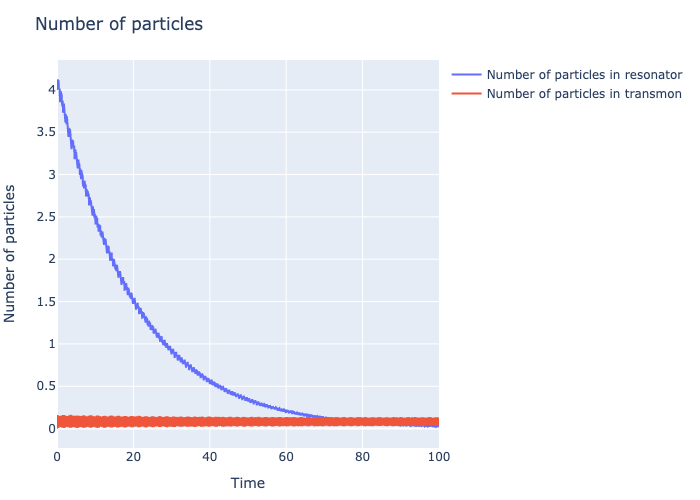

In [34]:
# plot the number of particles as a function of time 
plot_resonator = scatter(x=tlist, y=real(result.expect[1,:]), name="Number of particles in resonator")
plot_transmon = scatter(x=tlist, y=real(result.expect[2,:]), name="Number of particles in transmon")

layout = Layout(title="Number of particles",
                xaxis_title="Time",
                yaxis_title="Number of particles")

plot([plot_resonator, plot_transmon], layout)

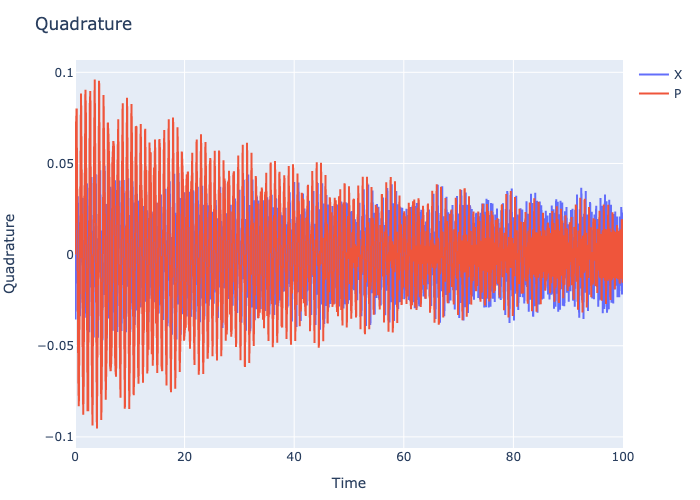

In [36]:
# plot the quadrature of the transmon
plot_X = scatter(x=tlist, y=real(result.expect[4,:]), name="X")
plot_P = scatter(x=tlist, y=imag(result.expect[4,:]), name="P")

layout = Layout(title="Quadrature",
                xaxis_title="Time",
                yaxis_title="Quadrature")

plot([plot_X, plot_P], layout)

## Effective drive

In [39]:
# run some simulations for, e.g. the number of particles in the resonator
e_ops_sc = [b_transmon' * b_transmon, b_transmon]

# initial state
ψ0_sc = fock(Nt, 0)

# time vector
tlist = 0:0.1:100

# run the simulation
p = (g=g, ϵd=ϵd, ωd=ωd, κ=κ)
result = mesolve(op_sc, ψ0_sc, tlist, [0*b_transmon], e_ops=e_ops_sc, params=p, saveat=tlist);

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)


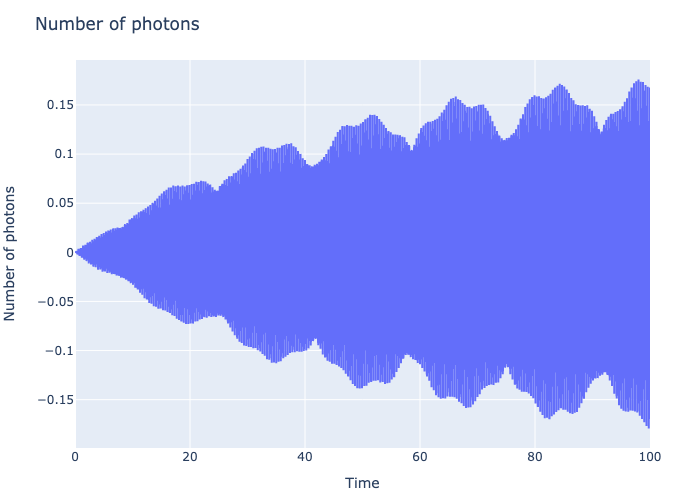

In [41]:
# plot the photon number
plot_transmon_sc = scatter(x=tlist, y=real(result.expect[2,:]), name="Quadrature")

layout = Layout(title="Number of photons",
                xaxis_title="Time",
                yaxis_title="Number of photons")

plot([plot_transmon_sc], layout)